image size:  (1039, 1039)


Text(0.5, 1.0, 'original cover image')

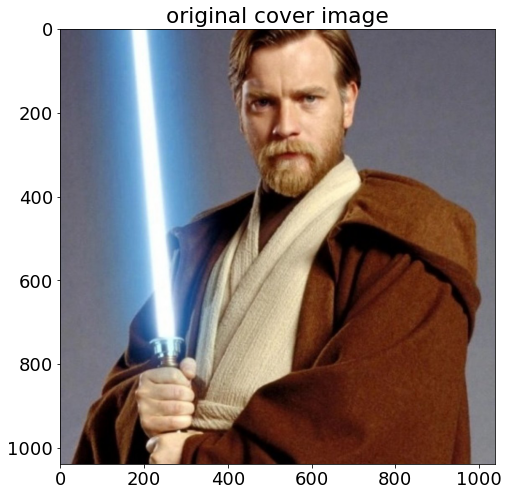

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
# PATH = "ImageSources\\jfif\\the_rock.jfif"
PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\png\\r2d2.png"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels

print("image size: ",image.size)

plt.figure()
plt.imshow(image)
plt.title("original cover image")

Functions for encoding and decoding

In [11]:
string="""It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    return [int(i)*gain for i in string_bits]

def text_from_bits_int(bits):
    # convert each element to string
    string_bits = [str(i) for i in bits]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital

Embed hidden message inside the absolute spektrum of the Fourier-Transform and reverse the process to save the resulting image as .png

MASK:

bin_encoded: [0, 14000, 0, 0, 14000, 0, 0, 14000, 0, 14000]
cut:  0.09185079444949293
message length: 4464
confirm: 4512.5


C:\Users\maxik\AppData\Local\Temp/ipykernel_32916/2170891409.py:31: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(cover_r_fft_masked))


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

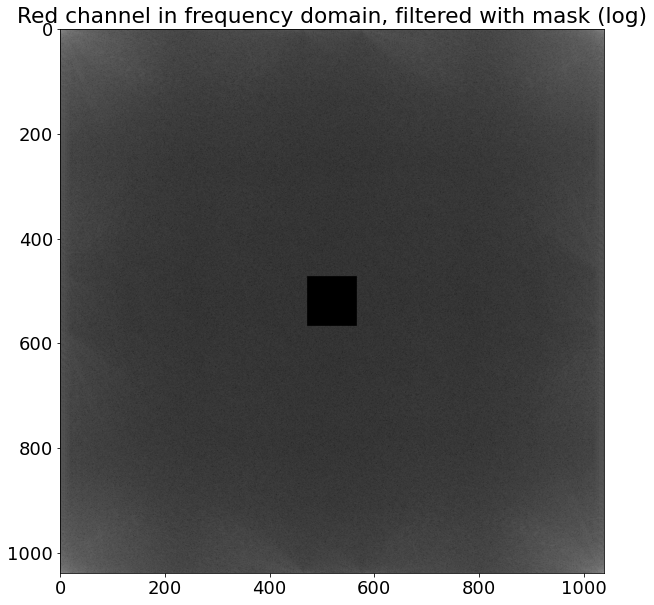

In [42]:
gain = 14000
bin_encoded =  text_to_bits_int(string, gain)
print("bin_encoded:", bin_encoded[:10])

def create_FFTmask(xlen, ylen, message):
    # calculate minimum part to be cut and add another 1% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(ylen*xlen))*1.01

    #cut off high frequencies from R channel
    mask = np.full((ylen, xlen), True)
    row_start = round(ylen/2*(1-cut))
    row_stop = round(ylen/2*(1+cut))
    col_start = round(xlen/2*(1-cut))
    col_stop = round(xlen/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

cover_r_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded)

cover_r_fft_masked = np.abs(np.fft.fft2(Rot))*cover_r_fft_mask
im = Image.fromarray(20*np.log10(cover_r_fft_masked))
plt.figure()
plt.imshow(im)
plt.title("Red channel in frequency domain, filtered with mask (log)")

C:\Users\maxik\AppData\Local\Temp/ipykernel_32916/331076248.py:31: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(fft_abs))


max value before normalization: 256.6636717147123
max value after normalization: 255


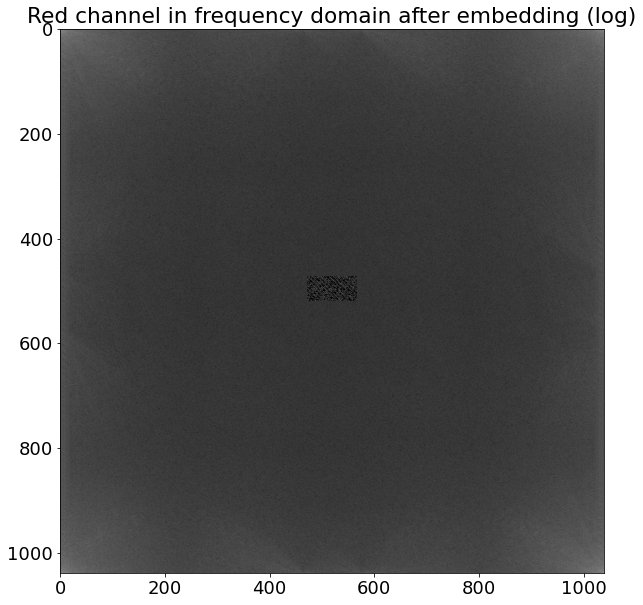

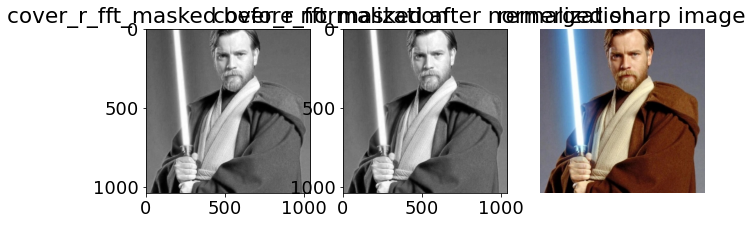

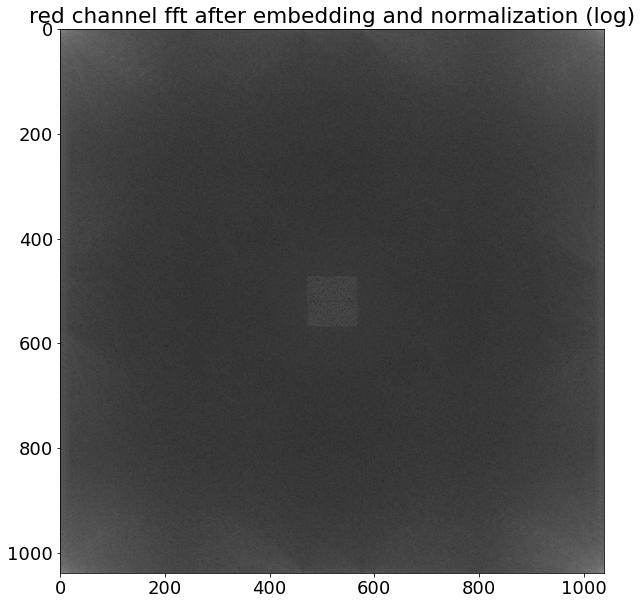

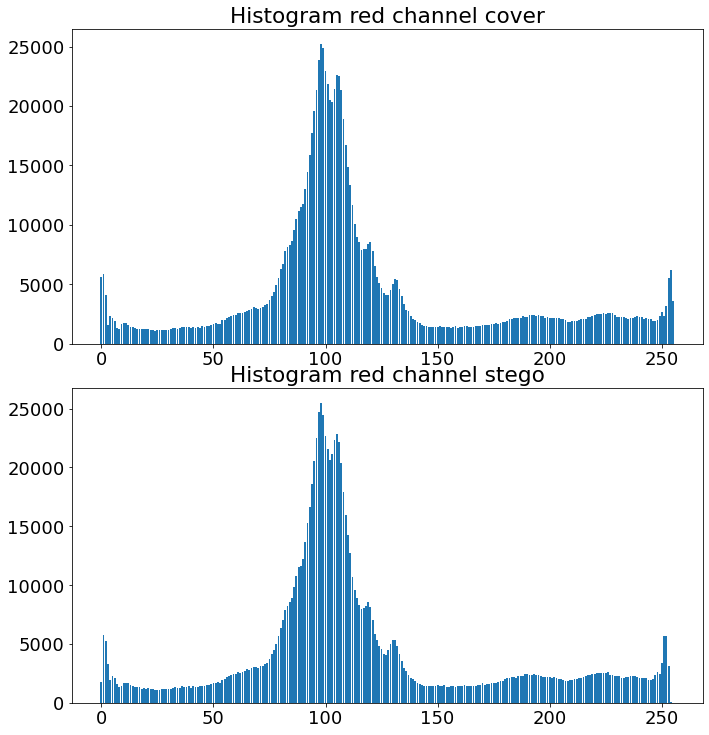

In [43]:
def embedBin2FFT(cover_channel, mask, message):
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    ylength, xlength = fft_abs.shape
    
    # write hidden message into filtered absolute part
    counter=0
    for i in range(ylength):
        # if cover_rows == 50:
        #     print("max values", np.max(cover_r_fft_abs[i]))
        for j in range(xlength):
            # write where coefficients are zero -> previously filtered out.
            if mask[i,j]==0:
                if counter<len(message):
                    # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                    fft_abs[i,j]=message[counter]
                    # print(cover_r_fft_abs[i,j])
                    counter+=1

    # # mirror reverse loop
    # counter = 0
    # for i in range(cover_rows-1, -1, -1):
    #     for j in range(cover_cols-1, -1, -1):
    #         if cover_r_fft_mask[i,j]==0:
    #             if counter < len(bin_encoded):
    #                 cover_r_fft_abs[i,j]=bin_encoded[counter]
    #                 counter+=1


    # plot absolute after embedding information
    im = Image.fromarray(20*np.log10(fft_abs))
    plt.figure()
    plt.imshow(im)
    plt.title("Red channel in frequency domain after embedding (log)")

    #IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_r_masked = np.fft.ifft2(fft_abs*np.exp(1j*np.angle(fft))).real
    # print(cover_r_masked)
    return cover_r_masked

# get channel with embedded binary data
cover_r_masked = embedBin2FFT(Rot, cover_r_fft_mask, bin_encoded)

# normalize output
cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
stego =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
# create steganogram
stego_img = Image.fromarray(stego)


# some plots
plt.figure()
plt.subplot(131)
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")
plt.subplot(132)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged sharp image")

print("max value before normalization:", np.max(cover_r_masked))
print("max value after normalization:", np.max(cover_r_masked_norm))


sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fft2(cover_r_masked_norm))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after embedding and normalization (log)")


# plot histograms
cover_r_hist = Rot.histogram()
stego_r_hist = stego_img.split()[0].histogram()
plt.figure()
plt.subplot(211)
plt.tight_layout()
plt.bar(np.arange(len(cover_r_hist)), cover_r_hist)
plt.title("Histogram red channel cover")
plt.subplot(212)
plt.bar(np.arange(len(stego_r_hist)), stego_r_hist)
plt.title("Histogram red channel stego")

im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png

Calculate mask from cut variable

max value stego_r:
 255


Text(0.5, 1.0, 'calculated fft mask')

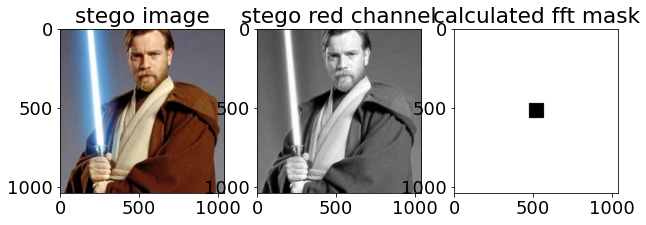

In [44]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png")

plt.figure()
plt.subplot(131)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

print("max value stego_r:\n", np.max(stego_r))

# calculate mask
def calculate_FFTmask(xlength, ylength, cut):
    stego_fft_mask = np.full((ylength, ylength), True)
    row_start = round(xlength/2*(1-cut))
    row_stop = round(xlength/2*(1+cut))
    col_start = round(ylength/2*(1-cut))
    col_stop = round(ylength/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    return stego_fft_mask

stego_fft_mask = calculate_FFTmask(*(image.size), cut)

plt.subplot(133)
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

[ 137 7116 1177 1054 6700  852  600 7238  963 6718 7120 7068 1477 8478
  715  589 1210  726 7009  560]
threshold 5025.5
bin_decoded:
It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the gamE, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana



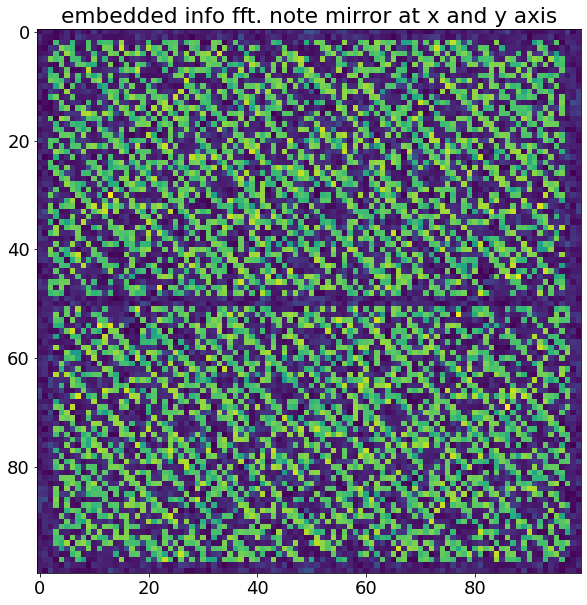

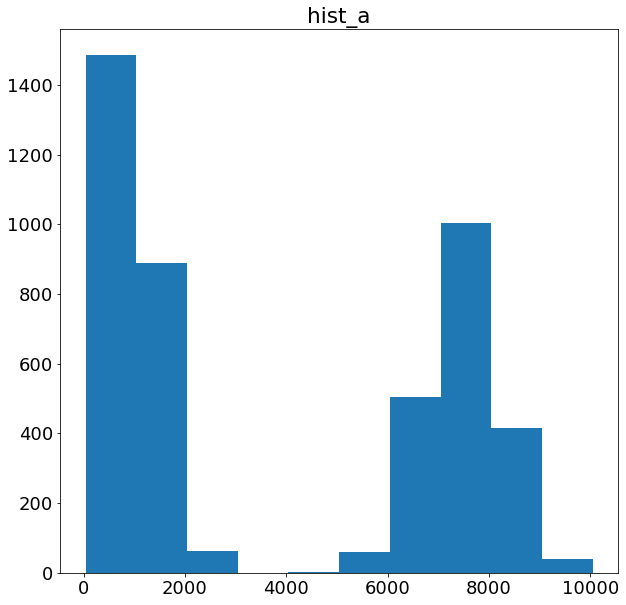

In [45]:
def get_message(stego_channel, mask, message_length):
    # transform R channel into frequency domain
    stego_r_fft =np.fft.fft2(stego_channel)
    stego_r_fft_abs = np.abs(stego_r_fft)
    ylen, xlen = stego_r_fft_abs.shape

    plt.figure()
    plt.imshow(stego_r_fft_abs[470:570, 470:570])
    plt.title("embedded info fft. note mirror at x and y axis")
    # calculate message length from mask
    # mask_tmp = mask[mask != True]
    # print(mask_tmp.shape)
    # message_len = np.multiply(*mask_tmp.shape)/2
    # print("message length: ", message_len)
    # create message buffer
    message=np.zeros(message_length, dtype='uint32')
    counter=0
    for i in range(ylen):
        for j in range(xlen):
            if mask[i,j]==0:
                if counter==message_length:
                    break
                message[counter] = stego_r_fft_abs[i,j]
                counter+=1 

    return message

message = get_message(stego_r, stego_fft_mask, len(bin_encoded))

print(message[:20])

# plot histogram
plt.figure()
plt.hist(message, histtype="bar")
plt.title("hist_a")

# calculate threshold
threshold = np.max(message)/2
print("threshold", threshold)

# convert message values to binary
binary = message2bin(message, threshold)

# convert binary to utf-8
Text = text_from_bits_int(binary)
print("bin_decoded:")
print(Text)

Now implement a gain finder algorithm

In [36]:
from FFT_stego import *

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# PATH = "ImageSources\\jfif\\darth_vader.jfif"
# PATH = "ImageSources\\jfif\\the_rock.jfif"
PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\png\\r2d2.png"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels

# input string
string="""It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""
def search(gain):
     # convert binary to utf-8
    bin_encoded =  text_to_bits_int(string, gain)

    cover_r_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded)

    cover_r_fft_masked = np.abs(np.fft.fft2(Rot))*cover_r_fft_mask

    # get channel with embedded binary data
    cover_r_masked = embedBin2FFT(Rot, cover_r_fft_mask, bin_encoded)

    # normalize output
    cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

    # merge layers
    stego =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')

    # create steganogram
    stego_img = Image.fromarray(stego)

    # plot histograms
    # cover_r_hist = Rot.histogram()
    # stego_r_hist = stego_img.split()[0].histogram()
    # plt.figure()
    # plt.subplot(121)
    # plt.tight_layout()
    # plt.bar(np.arange(len(cover_r_hist)), cover_r_hist)
    # plt.title("Histogram red channel cover")
    # plt.subplot(122)
    # plt.bar(np.arange(len(stego_r_hist)), stego_r_hist)
    # plt.title("Histogram red channel stego")

    im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png
    # ---------------------------------------------------------------------------------------------------------------------
    # ---------------------------------------------TRANSMISSION------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------------------------------
    stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png")

    stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

    stego_fft_mask = calculate_FFTmask(*(image.size), cut)

    message = get_message(stego_r, stego_fft_mask, len(bin_encoded))

    # plot histogram
    # plt.figure()
    # plt.hist(message, histtype="bar")
    # plt.title("hist_a")

    # calculate threshold
    threshold = np.max(message)/2
    print("threshold", threshold)

    # convert message values to binary
    binary = message2bin(message, threshold)

    return text_from_bits_int(binary)


# find the best gain with recursion
recursive_cnt = 0
def binary_search(low, high):
    global recursive_cnt
    recursive_cnt += 1
    
    if high >= low:

        gain = low + (high - low)//2
        print(f"gain after {recursive_cnt} iterations: ", gain)

        if recursive_cnt == 3:
            return gain
        
        try:
            Text = search(gain)    
        except UnicodeDecodeError:
            Text = ""

        if Text == string:
            # Search the left half
            return binary_search(low, gain-1)
            # Search the right half
        else:
            return binary_search(gain + 1, high)

    else:
        return -1
        

gain = 1000
prev_gain = 0

# reset text
Text = ""
while Text != string:
    try:
        Text = search(gain)
    except UnicodeDecodeError as err:
        prev_gain = gain
        Text = ""
        gain *= 2

print("prev gain", prev_gain, "\tgain:", gain)
print("gain overshoot at: ", gain)
gain  = binary_search(prev_gain, gain)
print("bin_decoded:\n", Text)

threshold 3389.0
threshold 4287.0
threshold 4615.5
threshold 4643.0
threshold 5240.0
prev gain 8000 	gain: 16000
gain overshoot at:  16000
gain after 1 iterations:  12000
threshold 4813.5
gain after 2 iterations:  14000
threshold 5025.5
gain after 3 iterations:  15000
bin_decoded: It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana



In [8]:
start = 10000

target = np.random.randint(0,100000)
print("target", target)
def mysterious_function(value):
    if value < target:
        return False
    else:
        return True


# def search(value):
#     pass
# print(search(start))


recursive_cnt = 0

def binary_search(low, high):
    global recursive_cnt
    recursive_cnt += 1
        
    if high >= low:

        mid = low + (high - low)//2

        if recursive_cnt == 3:
            return mid
        # Search the left half
        if mysterious_function(mid):
            return binary_search(low, mid-1)

        # Search the right half
        else:
            return binary_search(mid + 1, high)

    else:
        return -1


val = start
while not mysterious_function(val):
    prev_val = val
    val *= 2
print(binary_search(prev_val, val))

target 30799
32500
